# The Algorithm - Regression Trees
- Assuming all feature values are quantitative.  
- The below algorithm is to build a decision stump i.e. a decision tree with only one split.

### Init Stump Variables

- Split Variable $\rightarrow$ Where the variable on which the split is made will be stored
- RSS Value $\rightarrow$ The RSS value of the split
- Split Threshold $\rightarrow$ The threshold against which the split is made
- MSE $\rightarrow$ Meean Squared Error of the split
- Predictions $\rightarrow$ Prediction value for each region

$$RSS = \sum_{j = 1}^J \sum_{i \in R_j} (y_i - y_{R_j})^2$$  
$$MSE = \frac{1}{n} RSS$$

- Iterate over all feature variables
    - Calculate the `min` and `max` value of each feature
    - Generate `n` linearly spaced threshold values between `[min, max]` that will act as `thresholds`
    - Iterate over the `thresholds`
        - Split the attributes in `2-regions = [R1, R2]`, where `R1 = [feature < threshold]` and `R2 = [feature >= threshold]`
        - Calculate `RSS` for each region
        - Update the initialized variables
        
    - At the end of the iteration the initialized variables will hold:
        - An attribute of `X`
        - A `threshold` value, that divides the feature space into 2-regions based on the minimum RSS value which indicates the best split.
        - Each region will have it's corresponding prediction
    
**Note:** For a decision tree, the above steps are recursively performed for each subsequent regions, until a stopping criterion is met. This whole structure is easily represented in a tree data-structure; hence the name `decision tree`.

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from copy import deepcopy
from collections import defaultdict
from tqdm import tqdm
import random
random.seed(518123)

In [2]:
data = pd.read_csv('Boston.csv')

In [3]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Building a Decision Stump

In [4]:
def decision_stump(features, labels, num_thresholds=200):
    
    # Init Stump Variables
    stump = {'split_variable': "",
             'split_threshold': None,
             'rss_split': None,
             'mse_split': np.inf,
             'split_predictions': {'lower': None, 'higher': None}}
    
    # Iterate over all feature variables
    for column in features.columns:
        # Calculate the `min` and `max` value of each feature
        min_threshold, max_threshold = features[column].min(), features[column].max()
        
        # Generate `n` linearly spaced threshold values between `[min, max]` that will act as `thresholds`
        thresholds = np.arange(min_threshold, max_threshold, step=(max_threshold-min_threshold)/(num_thresholds-1))
        
        # Iterate over the `thresholds`
        for threshold in thresholds:
            # Split the attributes in `2-regions = [R1, R2]`, where `R1 = [feature < threshold]` and `R2 = [feature >= threshold]`
            less_than_idx = (features[features[column] < threshold]).index
            greater_than_idx = (features[features[column] >= threshold]).index
            
            # Calculate Predictions for each region
            pred_less_than = labels.loc[less_than_idx].mean()
            pred_greater_than = labels.loc[greater_than_idx].mean()
            
            # Calculate RSS
            RSS = ((labels.loc[less_than_idx] - pred_less_than)**2).sum() + ((labels.loc[greater_than_idx] - pred_greater_than)**2).sum()
            
            # Update stump attributes
            mse = (RSS / len(labels)).values[0]
            
            if stump['rss_split'] is not None:
                if mse < stump['mse_split']:
                    stump.update({'split_variable': column,
                                  'split_threshold': threshold,
                                  'rss_split': RSS.values[0],
                                  'mse_split': mse,
                                  'split_predictions': {'lower': pred_less_than.values[0],
                                                        'higher': pred_greater_than.values[0]}})
            else:
                stump.update({'split_variable': column,
                                  'split_threshold': threshold,
                                  'rss_split': RSS.values[0],
                                  'mse_split': mse,
                                  'split_predictions': {'lower': pred_less_than.values[0],
                                                        'higher': pred_greater_than.values[0]}})
    return stump

In [5]:
indexes = data.index.to_list()
random.shuffle(indexes)

split_pc = 0.8   # 80-20 split of train & test
split_num = int(len(indexes) * split_pc)
train_idx, test_idx = indexes[:split_num], indexes[split_num:]

In [6]:
X_train, X_test = data.loc[train_idx, 'rm lstat'.split()], data.loc[test_idx, 'rm lstat'.split()]
Y_train, Y_test = data.loc[train_idx, ['medv']], data.loc[test_idx, ['medv']]
stump = decision_stump(X_train, Y_train)
pprint(stump)

{'mse_split': 45.601216341880786,
 'rss_split': 18422.891402119836,
 'split_predictions': {'higher': 37.52898550724637,
                       'lower': 20.074925373134317},
 'split_threshold': 6.913869346733658,
 'split_variable': 'rm'}


## Predicting using Decision Stump

In [7]:
def stump_predict(features, decision_stump):
    
    less_than_idx = (features[decision_stump['split_variable']] < decision_stump['split_threshold'])
    greatere_than_idx = (features[decision_stump['split_variable']] >= decision_stump['split_threshold'])
    
    predictions = np.zeros(len(features))
    
    predictions[less_than_idx] = decision_stump['split_predictions']['lower']
    predictions[greatere_than_idx] = decision_stump['split_predictions']['higher']
    
    return predictions

In [8]:
test_mse = ((Y_test.values.reshape(-1) - stump_predict(X_test, stump))**2).sum()/len(Y_test)
print(f"Test MSE: {test_mse:>5.4f}")

Test MSE: 49.4678


## Boosted Stump

We have a decision stump and we can perform predictions using it. But as we can see that MSE value is quite large. This can be minimized by using a Boosted Tree.  
Some popular implementations available are Adaboost and XGBoost.  

Things required to build a boosted tree:

- A decision stump
- Learning Rate $(\eta)$, generally kept as $\eta = 0.01$
- Number of Boosted Trees $(B)$

<span style="color:red;font-weight:500;font-size:20px">
    🚨Crucial $\rightarrow$ Residual Calculations.
    It should be noted that we are trying to fit the residuals.
    <p>This will be again used during predictions.</p>
</span>

$\begin{align}
r_i & = Y_i & \dots\text{Initial Residuals} \\
r'_i & = r_i - \hat{f}(X_i) * \eta & \dots \text{$\hat{f}$ = decision stump} \\
\hat{f_b}(X) & = \sum_{b = 1}^{B} \eta \hat{f_b}(x) = \eta * \sum_{b = 1}^{B} \hat{f_b}(x) & \dots \text{Final Prediction using all the decision stumps fitted to the residuals} \\
&& \text{As $\eta$ is constant we can pull it out, compute the sum and then perform the product.}
\end{align}$

In [9]:
def printf(message):
    tqdm.write(message)

In [10]:
def boosted_prediction(features, boosted, lr = 0.01, max_idx=None):
    
    # Create an array equal to the length of the features filled with zeros
    preds = np.zeros(len(features))
    
    # Convert the boosted dict into data frame
    # Not completely necessary, but acts as a sanity check making sure each key has the same number of items
    boosted = pd.DataFrame(boosted)
    
    if max_idx is not None:
        boosted = boosted.head(max_idx)
    
    # As stated earlier we're looping over each row from the top.
    # we could've essentially looped through the range of length(boosted)
    # and considered the index of each key.
    for index, row in boosted.iterrows():
        preds += stump_predict(features, row)
    
    # Final predictions multiplied with the learning rate (eta) according to the above equation
    return preds * lr

In [11]:
def boosted_stump(features, labels, lr = 0.01, boosted_num = 10, verbose=False):
    
    # Initialize the necessary variables
    # We'll need a residual variable which we'll be updating multiple times
    # Initially the residuals will be same as the original labels
    # The boosted stump will be returned as a table, where each row is a decision stump
    # We'll keep a track of the training MSE which we'll later use for plotting
    """
    residuals = r_i + 
    """
    residuals = deepcopy(labels)
    boosted = defaultdict(list)
    training_mse = []
    
    # Looping through the range of decision stumps
    for tree_num in tqdm(range(boosted_num), ascii=True, dynamic_ncols=True, desc="Fitting Boosted Tree"):
        
        # Fit the features with the residuals
        stump = decision_stump(features, residuals)
        # Get predictions on the same features using the stump
        predictions = stump_predict(features, stump)
        
        # Calculate the residuals by substracting the predictions multiplied by the learning rate (lr)
        predictions = pd.DataFrame((predictions * lr), index=residuals.index, columns=residuals.columns)
        residuals = residuals - predictions
        
        # Update the boosted dictionary
        boosted['split_variable'].append(stump['split_variable'])
        boosted['split_threshold'].append(stump['split_threshold'])
        boosted['rss_split'].append(stump['rss_split'])
        boosted['mse_split'].append(stump['mse_split'])
        boosted['split_predictions'].append(stump['split_predictions'])
        
        # Calculate Boosted predictions and log the training MSE
        train_preds = boosted_prediction(features, boosted)
        train_preds = pd.DataFrame(train_preds, index=labels.index, columns=labels.columns)
        train_MSE = (((labels - train_preds)**2).sum()  / len(labels)).values[0]
        if verbose:
            printf(f"{tree_num+1:>2} Training MSE: {train_MSE:>5.4f}")
        training_mse.append(train_MSE)
    
    boosted["training_mse"] = training_mse
    
    return boosted

In [12]:
learning_rate = 0.01
boosted_tree_num = 1000

In [13]:
boosted = boosted_stump(features=X_train, labels=Y_train, lr=learning_rate, boosted_num=boosted_tree_num)

Fitting Boosted Tree: 100%|##########################################################################################################################################################| 100/100 [01:46<00:00,  1.07s/it]


In [14]:
boosted_df = pd.DataFrame(boosted)

In [15]:
boosted_df.head()

,split_variable,split_threshold,rss_split,mse_split,split_predictions,training_mse
0,rm,6.913869,18422.891402,45.601216,"{'lower': 20.074925373134317, 'higher': 37.528...",608.885037
1,rm,6.913869,18422.891402,45.601216,"{'lower': 19.874176119402957, 'higher': 37.153...",597.675689
2,rm,6.913869,18422.891402,45.601216,"{'lower': 19.675434358208992, 'higher': 36.782...",586.689407
3,rm,6.913869,18422.891402,45.601216,"{'lower': 19.478680014626896, 'higher': 36.414...",575.921752
4,rm,6.913869,18422.891402,45.601216,"{'lower': 19.28389321448058, 'higher': 36.0501...",565.368373


## Analysis

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

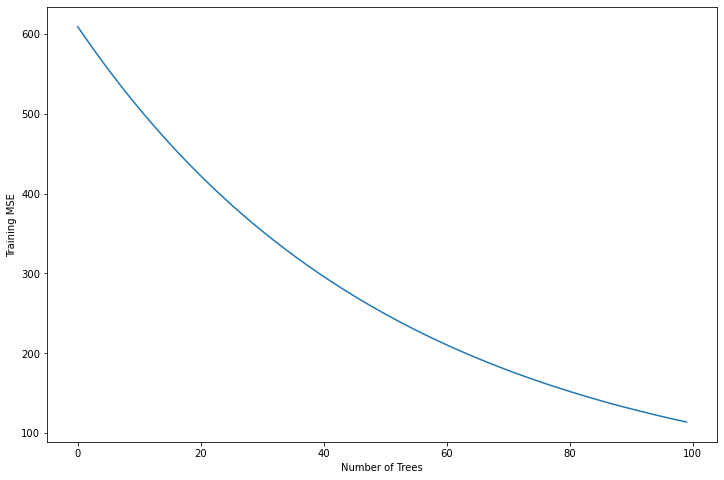

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(boosted_df['training_mse']);
plt.ylabel('Training MSE');
plt.xlabel('Number of Trees');

Now we'll look at how the test mse is changing with high number of boosted trees.

In [18]:
test_mse = []
for max_idx in range(boosted_tree_num):
    predictions = boosted_prediction(X_test, boosted, lr = 0.01, max_idx=max_idx)
    test_preds = pd.DataFrame(predictions, index=Y_test.index, columns=Y_test.columns)
    test_MSE = (((Y_test - test_preds)**2).sum()  / len(Y_test)).values[0]
    test_mse.append(test_MSE)

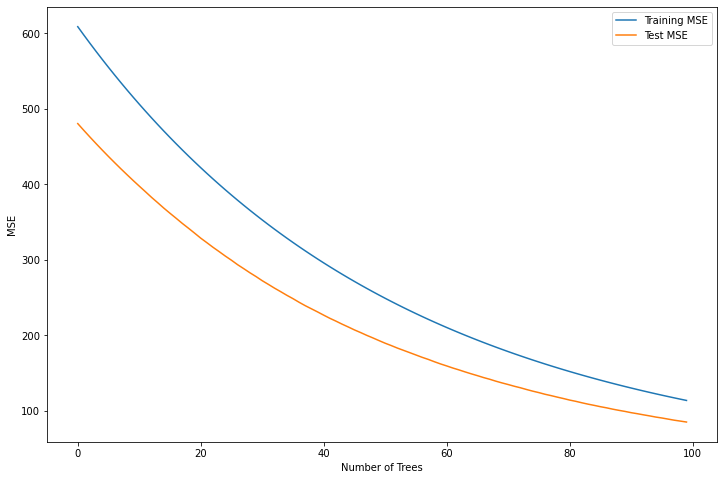

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(boosted_df['training_mse'], label='Training MSE');
plt.plot(test_mse, label='Test MSE');
plt.ylabel('MSE');
plt.xlabel('Number of Trees');
plt.legend();